In [1]:
import OpenCity

# Build geometry for state

In [2]:
fips=25
year=2017
geom_type='block'
centre= {'lat': 42.352927, 'lon': -71.059435}
centre_x_y=[centre['lon'], centre['lat']]

model_area_radius=5000
sim_area_radius=1000

state=OpenCity.US_State(state_fips=fips, year=year, 
#                         geom_type=geom_type
                       )
state.get_geometry()

Getting geometry (block_group) for state: Massachusetts


/Volumes/GoogleDrive/My Drive/OpenCity/OpenCity.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids=self.geom['geometry'].centroid


In [3]:
state.subset_geom_by_distance(centre_x_y, model_area_radius, 'model_area')
state.subset_geom_by_distance(centre_x_y, sim_area_radius, 'vis_area')

	 Subsetting zones by distance
	 Subsetting zones by distance


In [4]:
all_zones=state.return_geometry()
print(len(all_zones))

4985


In [5]:
sim_zones=state.return_geometry('vis_area')
print(len(sim_zones))

22


In [6]:
model_zones=state.return_geometry('model_area')
print(len(model_zones))

347


<AxesSubplot:>

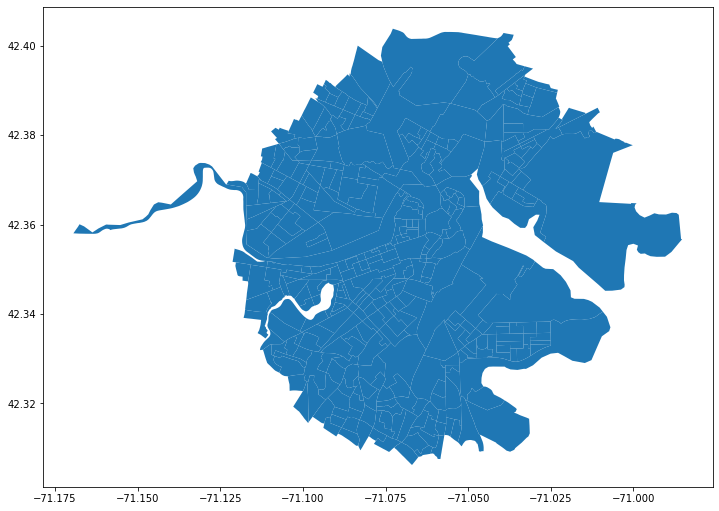

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(12,12))
model_zones.plot(ax=ax)

# Get commuting data for state from LEHD

In [8]:
state.get_lodes_data()

Getting WAC data from https://lehd.ces.census.gov/data/lodes/LODES7/
	 Formatting WAC data
Getting RAC data from https://lehd.ces.census.gov/data/lodes/LODES7/
	 Formatting RAC data
Getting OD data from https://lehd.ces.census.gov/data/lodes/LODES7/
	 Formatting OD data


The commuting data can be used to simulate a population

In [10]:
simpop_df=state.lodes_to_pop_table(model_subset_name='model_area', sim_subset_name='vis_area')

Using 5410 of 1498059 rows in OD data
0 of 5410


# Build mobility system for same area

The MobilitySystem class requries the networks to be specified as pandana networks. The network data to create the pandana network objects can be obtained using the osmnet library or using any other method.

In [ ]:
import pandana
import osmnet

networks={}

bbox=state.get_bounds(subset_name='model_area')
drive_nodes_df,drive_edges_df=osmnet.load.network_from_bbox(lat_min=bbox[1], lng_min=bbox[0], lat_max=bbox[3], 
                          lng_max=bbox[2], bbox=None, network_type='drive', 
                          two_way=True, timeout=180, 
                          custom_osm_filter=None)
drive_edges_df['travel_time']=drive_edges_df['distance']*50000/3600

drive_net=pandana.Network(drive_nodes_df["x"], drive_nodes_df["y"], drive_edges_df["from"], drive_edges_df["to"],
                 drive_edges_df[["distance", "travel_time"]])

networks['drive']=OpenCity.PdnaNetwork(drive_net)

Define modes of transportation

In [ ]:
drive_dict={
    'target_network_id': 'drive',
    'travel_time_metric': 'travel_time'}
modes={'drive': OpenCity.Mode(drive_dict)}

Create mobility system using the pandana network(s) and mode definition(s)

In [12]:
mob_sys=OpenCity.MobilitySystem(modes=modes,
                      networks=networks)

# Create the Simulation Model

In [13]:
sim=OpenCity.Simulation(simpop_df, mob_sys, model_zones)
simpop_df=sim.get_simpop_subset(simpop_df, sample_N=1000, sim_geoids=list(sim_zones.index))

Finding closest nodes to every zone centroid


In [14]:
simpop_df=sim.create_activity_schedules(simpop_df)

Scheduling activities
Chhosing locations for each activity


In [15]:
all_trips_df=sim.create_trip_table(simpop_df)

Choosing modes


In [16]:
route_table=sim.get_routes_table(all_trips_df)

In [17]:
route_gdf=sim.route_table_to_geo(route_table)

In [18]:
route_gdf.head()

,from_activity,to_activity,from_zone,to_zone,person_id,start_time,age,earnings,industry,mode,from_node_drive,to_node_drive,node_path,attributes,line_string
0,H,W,250250709001,250250303003,93201,34966.848524,30to54,3333plus,other,drive,61355237,6162811202,"[61355237, 61356740, 61353496, 61356831, 61356...","{'distance': [75.653759, 38.542321, 38.035189,...","LINESTRING (-71.07698 42.33857, -71.07629 42.3..."
1,W,O,250250303003,250250603012,93201,47073.758994,30to54,3333plus,other,drive,6162811202,61458148,"[6162811202, 6990594259, 731633442, 731633428,...","{'distance': [14.43331, 35.39799, 4.53493, 43....","LINESTRING (-71.05979 42.35964, -71.05975 42.3..."
2,O,W,250250603012,250250303003,93201,49406.453424,30to54,3333plus,other,drive,61458148,6162811202,"[61458148, 61355394, 61377815, 61360892, 61458...","{'distance': [64.812019, 91.529112, 92.063419,...","LINESTRING (-71.03602 42.33064, -71.03524 42.3..."
3,W,H,250250303003,250250709001,93201,66003.474527,30to54,3333plus,other,drive,6162811202,61355237,"[6162811202, 6990594259, 731633442, 61463265, ...","{'distance': [14.43331, 35.39799, 39.772767, 6...","LINESTRING (-71.05979 42.35964, -71.05975 42.3..."
4,H,W,250250701017,250250303002,83659,24358.991766,30to54,3333plus,other,drive,61580134,61557032,"[61580134, 61341258, 61367090, 61354256, 61385...","{'distance': [56.561232, 55.18748, 59.683831, ...","LINESTRING (-71.06052 42.35136, -71.06119 42.3..."


# Visualising Outputs

Get resulting trips as a GeoDataFrame of 'LineString's

<AxesSubplot:>

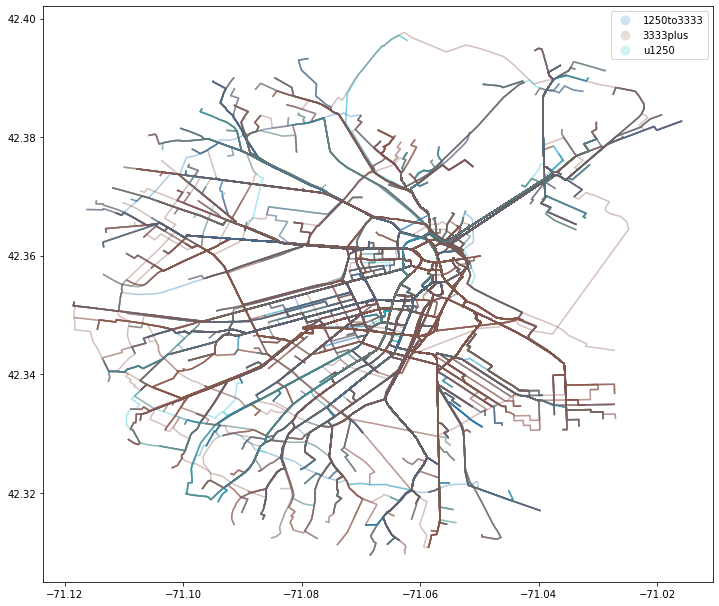

In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(12,12))
route_gdf.plot(column='earnings', legend=True, alpha=0.2, ax=ax)

Get resulting trips as a geojson compatible with the [kepler.gl](https://kepler.gl/) [Trips Layer](https://deck.gl/docs/api-reference/geo-layers/trips-layer). 'start_day_time_stamp' should be the timestamp in epoch seconds format at midnight at the beginning of the day being simulated.

In [20]:
start_day_time_stamp=1578268800
geo_dict=sim.route_gdf_to_trips_geojson(route_gdf, start_day_time_stamp)

In [21]:
geo_dict.keys()

dict_keys(['type', 'features', 'bbox'])

In [22]:
geo_dict['features'][0]

{'id': '0',
 'type': 'Feature',
 'properties': {'age': '30to54',
  'earnings': '3333plus',
  'from_activity': 'H',
  'from_node_drive': 61355237,
  'from_zone': '250250709001',
  'industry': 'other',
  'mode': 'drive',
  'person_id': 93201,
  'start_time': 34966.84852360197,
  'to_activity': 'W',
  'to_node_drive': 6162811202,
  'to_zone': '250250303003'},
 'geometry': {'type': 'LineString',
  'coordinates': [[-71.0769757, 42.3385729, 0, 1578303766],
   [-71.076287, 42.339024, 0, 1578304817],
   [-71.07594, 42.339257, 0, 1578305352],
   [-71.075594, 42.339484, 0, 1578305881],
   [-71.075247, 42.339714, 0, 1578306413],
   [-71.074903, 42.339937, 0, 1578306935],
   [-71.074343, 42.340305, 0, 1578307791],
   [-71.074006, 42.340042, 0, 1578308351],
   [-71.073434, 42.340396, 0, 1578309202],
   [-71.072751, 42.340841, 0, 1578310242],
   [-71.0720464, 42.3413062, 0, 1578311321],
   [-71.0715902, 42.3415743, 0, 1578311986],
   [-71.0713824, 42.3416907, 0, 1578312284],
   [-71.070602, 42.34215

In [23]:
state.od.to_csv('outputs/06_od.csv')